## Importing stuff

In [1]:
import sys, os
import tsai
from tsai.all import *
from tsai.imports import *
from tsai.models.layers import *
display(HTML("<style>.container {width:95% !important; }</style>"))

In [2]:
import sys, os
import numpy as np
import pandas as pd
import pickle

In [3]:
sys.path.append(os.path.abspath('../../'))
from utils import utils
from utils.utils import evaluate_experiment
sys.path.append(os.path.abspath('../'))
from timeseries_utils import *

In [4]:
from fastai import *
from fastai.basic_data import *
from fastai.basic_train import *
from fastai.train import *
from fastai.metrics import *
from fastai.torch_core import *
from fastai.layers import *
from fastai.core import *

## Printing configs

In [5]:
print('tsai       :', tsai.__version__)
print('fastai2    :', fastai2.__version__)
print('fastcore   :', fastcore.__version__)
print('torch      :', torch.__version__)
print('scipy      :', sp.__version__)
print('numpy      :', np.__version__)
print('pandas     :', pd.__version__)
print(f'Total RAM  : {bytes2GB(psutil.virtual_memory().total):5.2f} GB')
print(f'Used RAM   : {bytes2GB(psutil.virtual_memory().used):5.2f} GB')
print('n_cpus     :', cpus)
iscuda = torch.cuda.is_available()
if iscuda: print('device     : {} ({})'.format(device, torch.cuda.get_device_name(0)))
else: print('device     :', device)

tsai       : 0.1.0
fastai2    : 0.0.17
fastcore   : 0.1.17
torch      : 1.4.0
scipy      : 1.4.1
numpy      : 1.18.1
pandas     : 1.0.4
Total RAM  : 62.75 GB
Used RAM   : 11.07 GB
n_cpus     : 16
device     : cuda (GeForce GTX 1080)


## Loading data

In [6]:
path_to_data='../../../'

In [7]:
data=np.load(os.path.abspath(path_to_data+'data-002.npy'),allow_pickle=True)
Y=np.load(path_to_data+'Y.npy',allow_pickle=True)
labels =pd.read_csv(path_to_data+'labels.csv')

In [8]:
train_fold=8
val_fold=9
test_fold=10

# 10th fold for testing (9th for now)
X_test = data[labels.strat_fold == test_fold]
y_test = Y[labels.strat_fold == test_fold]
# 9th fold for validation (8th for now)
X_val = data[labels.strat_fold == val_fold]
y_val = Y[labels.strat_fold == val_fold]
# rest for training
X_train = data[labels.strat_fold <= train_fold]
y_train = Y[labels.strat_fold <= train_fold]

In [9]:
X_train.shape ,X_val.shape

((17111, 1000, 12), (2156, 1000, 12))

In [10]:
# Preprocess signal data
X_train, X_val, X_test = utils.preprocess_signals(X_train, X_val, X_test,'/content/')
n_classes = y_train.shape[1]
# X_train = np.reshape(X_train,[X_train.shape[0],X_train.shape[2],X_train.shape[1]])
# X_val = np.reshape(X_val,[X_val.shape[0],X_val.shape[2],X_val.shape[1]])
X_test = np.reshape(X_test,[X_test.shape[0],X_test.shape[2],X_test.shape[1]])

In [11]:
display(X_train.shape)
_, features, seq_len = X_train.shape

(17111, 1000, 12)

In [12]:
X_train.shape, X_val.shape

((17111, 1000, 12), (2156, 1000, 12))

In [13]:
y_train.shape, y_val.shape

((17111, 5), (2156, 5))

## Instantiating the model

In [14]:
#export
class Block(Module):
    def __init__(self, ni, nf, ks=[7, 5, 3], act_fn='relu'):
        self.conv1 = Conv1d(ni, nf, ks[0], padding='same', act_fn=act_fn)
        self.conv2 = Conv1d(nf, nf, ks[1], padding='same', act_fn=act_fn)
        self.conv3 = Conv1d(nf, nf, ks[2], padding='same', act_fn=False)

        # expand channels for the sum if necessary
        self.shortcut = noop if ni == nf else Conv1d(ni, nf, ks=1, act_fn=False)
        self.act_fn = get_act_layer(act_fn)

    def forward(self, x):
        res = x
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        sc = self.shortcut(res)
        x += sc
        x = self.act_fn(x)
        return x


class ResCNN(Module):
    def __init__(self, c_in, c_out):
        nf = 64
        self.block = Block(c_in, nf, ks=[7, 5, 3], act_fn='relu')
        self.conv1 = Conv1d(nf, nf * 2, ks=3, padding='same', act_fn='leakyrelu', act_kwargs={'negative_slope':.2})
        self.conv2 = Conv1d(nf * 2, nf * 4, ks=3, padding='same', act_fn='prelu')
        self.conv3 = Conv1d(nf * 4, nf * 2, ks=3, padding='same', act_fn='elu', act_kwargs={'alpha':.3})
        self.gap = nn.AdaptiveAvgPool1d(1)
        self.lin = nn.Linear(nf * 2, c_out)

    def forward(self, x):
        x = self.block(x)
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.gap(x).squeeze(-1)
        return self.lin(x)

In [15]:
# utility functions
    
class SqueezeExcite1d(nn.Module):
    '''squeeze excite block as used for example in LSTM FCN'''
    def __init__(self,channels,reduction=16):
        super().__init__()
        channels_reduced = channels//reduction
        self.w1 = torch.nn.Parameter(torch.randn(channels_reduced,channels).unsqueeze(0))
        self.w2 = torch.nn.Parameter(torch.randn(channels, channels_reduced).unsqueeze(0))

    def forward(self, x):
        #input is bs,ch,seq
        z=torch.mean(x,dim=2,keepdim=True)#bs,ch
        intermed = F.relu(torch.matmul(self.w1,z))#(1,ch_red,ch * bs,ch,1) = (bs, ch_red, 1)
        s=F.sigmoid(torch.matmul(self.w2,intermed))#(1,ch,ch_red * bs, ch_red, 1=bs, ch, 1
        return s*x #bs,ch,seq * bs, ch,1 = bs,ch,seq

def weight_init(m):
    '''call weight initialization for model n via n.appy(weight_init)'''
    if isinstance(m, nn.Conv1d) or isinstance(m, nn.Linear):
        nn.init.kaiming_normal_(m.weight)
        if m.bias is not None:
            nn.init.zeros_(m.bias)
    if isinstance(m, nn.BatchNorm1d):
        nn.init.constant_(m.weight,1)
        nn.init.constant_(m.bias,0)
    if isinstance(m,SqueezeExcite1d):
        stdv1=math.sqrt(2./m.w1.size[0])
        nn.init.normal_(m.w1,0.,stdv1)
        stdv2=math.sqrt(1./m.w2.size[1])
        nn.init.normal_(m.w2,0.,stdv2)

In [16]:
loss = F.binary_cross_entropy_with_logits
input_size=X_train.shape[1]
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
#batchsize
bs=128
model = ResCNN(12,5).to(device)
X_train_list = [l.astype(np.float32) for l in X_train]
X_val_list = [l.astype(np.float32) for l in X_val]
y_train_list = [l.astype(np.float32) for l in y_train]
y_val_list = [l.astype(np.float32) for l in y_val]

In [17]:
len(X_train), len(X_val)

(17111, 2156)

In [18]:
metrics = [accuracy]
wd=1e-2

chunkify_train=False
chunkify_valid=True
chunk_length_valid=input_size
min_chunk_length=input_size#chunk_length

stride_length_train=input_size#chunk_length_train//8
stride_length_valid=input_size//2#chunk_length_valid


df_train = pd.DataFrame({"data":range(len(X_train_list)),"label":y_train_list})
df_valid = pd.DataFrame({"data":range(len(X_val_list)),"label":y_val_list})

tfms_ptb_xl = [ToTensor()]

ds_train=TimeseriesDatasetCrops(df_train,input_size,num_classes=5,chunk_length= 0,min_chunk_length=min_chunk_length,stride=stride_length_train,transforms=tfms_ptb_xl,annotation=False,col_lbl ="label",npy_data=X_train_list)
ds_valid=TimeseriesDatasetCrops(df_valid,input_size,num_classes=5,chunk_length=chunk_length_valid,min_chunk_length=min_chunk_length,stride=stride_length_valid,transforms=tfms_ptb_xl,annotation=False,col_lbl ="label",npy_data=X_val_list)

db = DataBunch.create(ds_train,ds_valid,bs=bs)
learn = Learner(db,model, loss_func=loss, metrics=metrics,wd=wd,path='/content/models')
learn.model.apply(weight_init)

ResCNN(
  (block): Block(
    (conv1): Sequential(
      (0): Conv1dSame(
        (conv1d_same): Conv1d(12, 64, kernel_size=(7,), stride=(1,))
      )
      (1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
    )
    (conv2): Sequential(
      (0): Conv1dSame(
        (conv1d_same): Conv1d(64, 64, kernel_size=(5,), stride=(1,))
      )
      (1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
    )
    (conv3): Sequential(
      (0): Conv1dSame(
        (conv1d_same): Conv1d(64, 64, kernel_size=(3,), stride=(1,))
      )
      (1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (shortcut): Sequential(
      (0): Conv1dSame(
        (conv1d_same): Conv1d(12, 64, kernel_size=(1,), stride=(1,))
      )
      (1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (act_fn): ReLU()
  )
  (conv1): Sequential(

## Training

In [19]:
learn.fit_one_cycle(25,1e-1)

epoch,train_loss,valid_loss,accuracy,time
0,0.349030,0.353150,0.060297,00:12
1,0.319184,0.354521,0.183488,00:12
2,0.312541,0.415573,0.110019,00:12
3,0.307657,0.379178,0.152412,00:12
4,0.309478,0.354127,0.126531,00:12
5,0.300962,0.335012,0.103432,00:12
6,0.299205,0.326852,0.125325,00:12
7,0.300546,0.421008,0.199072,00:12
8,0.294126,0.381865,0.072542,00:12
9,0.283564,0.327970,0.075325,00:12


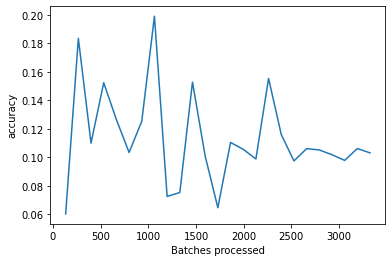

In [20]:
learn.recorder.plot_metrics()

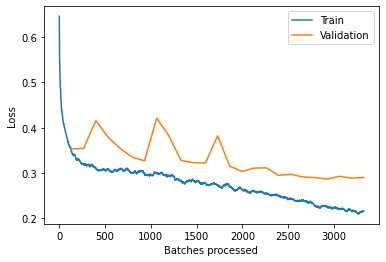

In [21]:
learn.recorder.plot_losses()

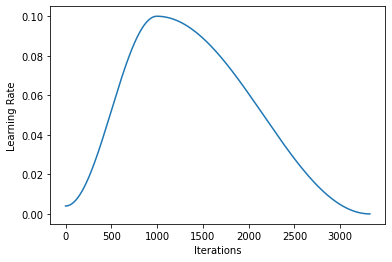

In [22]:
learn.recorder.plot_lr()

## Evaluating

In [23]:
preds,targs=learn.get_preds()
preds = preds.numpy()
targs = targs.numpy()

In [24]:
preds.shape, y_val.shape, targs.shape

((2156, 5), (2156, 5), (2156, 5))

In [25]:
thresholds=None
tr_df_point = evaluate_experiment( targs, preds)
print(tr_df_point)

   macro_auc      Fmax
0   0.925911  0.806946


/home/pedropva/time_series/ecg-ml-dl/utils/utils.py:87: RuntimeWarning: invalid value encountered in true_divide
  F = (2*PR*RC)/(PR+RC)
